# Introduction

The notebooks is divided as follows

1. EDA and Dataset Construction
    * Sentiment Classification Dataset
    * Summary Generation and QA Dataset
2. Task: Sentiment Classification
    * Converting Sentiment to numerical label
    * Class Imbalace and Sampling ratio calculation
    * Creating Dataset Class for torch Model
    * Defining Encoder model 
    * Creating Traning and valdation functions
    * Intializing and traning the models
    * Result and conclusion
    * Future direction and experiment possible
    

In [1]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModel, AutoConfig
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from torcheval.metrics import MulticlassConfusionMatrix,MulticlassF1Score
from tqdm import tqdm


import torch.nn as nn
import pandas as pd
import torch
import ipdb
import ast

# EDA and Dataset Construction

In [2]:
data = pd.read_csv("topical_chat.csv")

In [3]:
data.head()

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpful...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper


In [4]:
data['sentiment'].unique()

array(['Curious to dive deeper', 'Happy', 'Neutral', 'Surprised',
       'Disgusted', 'Sad', 'Fearful', 'Angry'], dtype=object)

In [5]:
len(data)

188378

Removing the rows with null values 

In [6]:
data = data.dropna()

In [7]:
len(data)

188373

five rows were removed

### Sentiment Analysis Dataset

In [8]:
sentiment_data = data[["message","sentiment"]]

In [9]:
sentiment_data.to_csv("dataset/sentiment_data.csv",index=False)

### Summary Generation and QA Dataset

In [10]:
summ_dataset = []
conv_id = []
for idx,cov in data.groupby(['conversation_id']):
    summ_dataset.append("\n".join(cov['message']).strip("\n"))
    conv_id.append(idx)
    # print(cov)
    # out = ''
    # for x in cov['message']:
    #     if x in not None:
    #         out+=x+'\n'
    # summ_dataset.append(out.strip('\n'))    
    # try:
    #     summ_dataset.append("\n".join(cov['message']).strip("\n"))
    # except:
    #     print(f"ERROR: In conversatoin id {idx}")
    #     out = ''
    #     for x in cov['message']:
    #         out += "\n"+str(x)
    #     out.strip('\n')
    #     print(out)
print(len(summ_dataset))

8628


In [11]:
pd.DataFrame({'conversation':summ_dataset[:100] , "conv_id":conv_id[:100]}).to_csv('dataset/100_conversation.csv',index=False)

In [12]:
pd.DataFrame({'conversation':summ_dataset , "conv_id":conv_id}).to_csv('dataset/conversation.csv',index=False)

# Task: Sentiment Classification

In [13]:
sentiment_data = pd.read_csv("dataset/sentiment_data.csv")

In [14]:
sentiment_data['sentiment'].unique()

array(['Curious to dive deeper', 'Happy', 'Neutral', 'Surprised',
       'Disgusted', 'Sad', 'Fearful', 'Angry'], dtype=object)

### Converting sentiment to numerical labels

In [15]:
str2cls = {
 'Curious to dive deeper':0, 
 'Happy':1, 
 'Neutral':2, 
 'Surprised':3,
 'Disgusted':4, 
 'Sad':5,
 'Fearful':6,
 'Angry':7
}

In [16]:
sentiment_data['sentiment'] = sentiment_data['sentiment'].replace(str2cls)

In [17]:
sentiment_data['sentiment'].unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

### Class Imbalace and Sampling ratio calculation

In [18]:
cls_dist = (sentiment_data['sentiment'].value_counts()/len(sentiment_data))

In [19]:
cls_dist

0    0.429398
2    0.219602
3    0.162640
1    0.157215
5    0.013447
4    0.007602
6    0.005447
7    0.004650
Name: sentiment, dtype: float64

The classes are higly imbalanced so some oversampling or weights will be needed to make the data balanced

In [20]:
cls_weights = cls_dist**(-1)/100

In [21]:
cls_weights = { key:val for key,val in zip(cls_weights.index,cls_weights) }

In [22]:
cls_weights

{0: 0.023288414701991663,
 2: 0.045537022264123574,
 3: 0.06148545875901688,
 1: 0.0636072936012156,
 5: 0.7436754836162653,
 4: 1.315453910614525,
 6: 1.8359941520467837,
 7: 2.150376712328767}

The above is the sampling ratio that we will be using 

In [23]:
[ b for a,b in cls_weights.items()] * sentiment_data['sentiment'].value_counts()

0    1883.73
2    1883.73
3    1883.73
1    1883.73
5    1883.73
4    1883.73
6    1883.73
7    1883.73
Name: sentiment, dtype: float64

We see that when classes are multiplied with class weigths they became balanced

### Creating Dataset Class for torch Model

In [24]:
class TaskADataset(Dataset):
    
    def over_sampling(self,data_base,weights):
        # Oversampling is done so that the dataset is balanced
        # weigts: dict type has sampling ration for each class
        data = []
        for idx,gp in data_base.groupby(['sentiment']):
            out = gp.sample(frac=weights[idx], replace=True,random_state=43)
            data.append(out)
        data = pd.concat(data)
        print(data.describe())
        return data

    def __init__(self, data, tokenizer, max_len:int, weights={i:1 for i in range(8)}):
        self.data = self.over_sampling(data,weights)
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        data = self.data.iloc[index]
        text = data.message
        label = data.sentiment
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

### Defining Encoder model

In [25]:
class TaskA_Model(nn.Module):

    def __init__(self, model_name, num_classes,embedding_size=768):
        super(TaskA_Model, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.L1 = nn.Linear(embedding_size, 200)
        self.L2 = nn.Linear(200,25)
        self.classifier = nn.Linear(25,num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        outputs = self.L1(outputs.pooler_output)
        outputs = self.L2(outputs)
        class_weights = self.classifier(outputs)
        probs = self.softmax(class_weights)
        return probs

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Creating Traning and valdation functions

In [27]:
def val_model(model,criterion,metrics,th,val_dataloader,min_val_loss=-1):
    
    
    model.eval()
    predictions = []
    total_val_loss = 0
    for batch_idx,data in tqdm(enumerate(val_dataloader),total = len(val_dataloader)):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        label = data['label'].to(device)
        output = model(input_ids, attention_mask)
        pred = torch.zeros(len(label))
        pred[output[:,1]>th] = 1
        loss = criterion(output,label)
        pred = pred.to(torch.int64)
        label = label.to(torch.int64)
        label = label.to('cpu')
        predictions.append(pred)
        
        for m in metrics:
            m.update(pred,label)
        
        total_val_loss+=loss.item()
    val_loss = total_val_loss/len(val_dataloader)
    if val_loss<min_val_loss:
        min_val_loss = val_loss
    #     torch.save(model.state_dict(),"./model_bert_freeze")
        print("Model Saved")

    print("Macro F1: ",metrics[0].compute())
    print("Micro F1: ",metrics[1].compute())
    print("Confusion Matric: \n",metrics[2].compute())
    if len(metrics)>3:
        print("Accuracy: ",metrics[3].compute())
    for m in metrics:
            m.reset()
    return val_loss


def train_model(model,optimizer,criterion,scheduler,num_epoch,F1_macro_metric,F1_micro_metric,confusion_matrix,th,val_dataloader):
    min_val_loss = 1000
    for epoch in range(num_epoch):
        model.train()
        tot_loss = 0
        for batch_idx, data in tqdm(enumerate(train_loader),total=len(train_loader)):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            label = data['label'].to(device)
            optimizer.zero_grad()
            output = model(input_ids, attention_mask)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
        
        val_loss = val_model( model = model,
                              criterion = criterion,
                              metrics = [F1_macro_metric, F1_micro_metric,confusion_matrix],
                              th = th,
                              val_dataloader = val_dataloader,
                              min_val_loss = min_val_loss)
        
        min_val_loss = min(min_val_loss,val_loss)
        print(f"Epoch Loss : {tot_loss/len(train_loader)} Val Loss: {val_loss}")
        scheduler.step(tot_loss/len(train_loader))


### Intializing and traning the models

Split the data into train val and test with stratify sampling

In [28]:
from sklearn.model_selection import train_test_split

train,val = train_test_split(sentiment_data,test_size=0.1,stratify=sentiment_data['sentiment'],random_state=43)

In [20]:
import os

In [21]:
max_len = max( [ len(i.split()) for i in train["message"] ] )+100
print("Max length of message: ", max_len)

model_name = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
nclasses = len(cls_weights)
model = TaskA_Model(model_name,num_classes=nclasses).to(device)

Max length of message:  227


In [23]:
if os.path.exists('model_bert_freeze'):
    model.load_state_dict(torch.load('model_bert_freeze'))
    print("Pretrained model exists and loaded")

Pretrained model exists and loaded


If only the linear layer traning is needed

In [23]:
# for params in model.bert.parameters():
#     params.requires_grad = False

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',threshold=1e-3)
num_epoch = 10
th = 0.5
F1_macro_metric = MulticlassF1Score(average="macro", num_classes=nclasses)
F1_micro_metric = MulticlassF1Score(average="micro", num_classes=nclasses)
confusion_matrix = MulticlassConfusionMatrix(num_classes=nclasses)

train_dataset = TaskADataset(train, tokenizer, max_len,weights=cls_weights)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TaskADataset(val,tokenizer,max_len)
val_dataloader = DataLoader(val_dataset,batch_size=16)


train_model(model = model,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            num_epoch=num_epoch,
            F1_macro_metric=F1_macro_metric,
            F1_micro_metric=F1_micro_metric,
            confusion_matrix=confusion_matrix,
            th=th,
            val_dataloader=val_dataloader)

          sentiment
count  13564.000000
mean       3.500664
std        2.291469
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max        7.000000
          sentiment
count  18838.000000
mean       1.247054
std        1.350861
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        7.000000


100%|████████████████████████| 1178/1178 [03:01<00:00,  6.49it/s]


Model Saved
Macro F1:  tensor(0.1210)
Micro F1:  tensor(0.4477)
Confusion Matric: 
 tensor([[7.4670e+03, 6.2200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.9950e+03, 9.6700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.5570e+03, 5.8000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.8190e+03, 2.4500e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4400e+02, 9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.6000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+0

100%|████████████████████████| 1178/1178 [03:02<00:00,  6.47it/s]


Model Saved
Macro F1:  tensor(0.1236)
Micro F1:  tensor(0.4385)
Confusion Matric: 
 tensor([[6.9060e+03, 1.1830e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.6070e+03, 1.3550e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.1230e+03, 1.0140e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.5580e+03, 5.0600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.3500e+02, 8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.3200e+02, 2.1000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.7000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.4000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+0

100%|████████████████████████| 1178/1178 [03:01<00:00,  6.49it/s]


Macro F1:  tensor(0.1196)
Micro F1:  tensor(0.4490)
Confusion Matric: 
 tensor([[7.5930e+03, 4.9600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.0960e+03, 8.6600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.6550e+03, 4.8200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.8820e+03, 1.8200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4100e+02, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4600e+02, 7.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.6000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch: 

100%|████████████████████████| 1178/1178 [03:01<00:00,  6.48it/s]


Model Saved
Macro F1:  tensor(0.1230)
Micro F1:  tensor(0.4427)
Confusion Matric: 
 tensor([[7.1760e+03, 9.1300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.7990e+03, 1.1630e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.4550e+03, 6.8200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.6840e+03, 3.8000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.3800e+02, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4700e+02, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.1000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+0

100%|████████████████████████| 1178/1178 [03:01<00:00,  6.49it/s]


Model Saved
Macro F1:  tensor(0.1241)
Micro F1:  tensor(0.4419)
Confusion Matric: 
 tensor([[7.0400e+03, 1.0490e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.6770e+03, 1.2850e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.3010e+03, 8.3600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.5970e+03, 4.6700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.3800e+02, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.3900e+02, 1.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.8000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.1000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+0

100%|████████████████████████| 1178/1178 [03:01<00:00,  6.50it/s]


Macro F1:  tensor(0.1221)
Micro F1:  tensor(0.4415)
Confusion Matric: 
 tensor([[7.1750e+03, 9.1400e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.8200e+03, 1.1420e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.3950e+03, 7.4200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.7230e+03, 3.4100e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.3700e+02, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4700e+02, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.8000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.1000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch: 

100%|████████████████████████| 1178/1178 [03:01<00:00,  6.48it/s]


Model Saved
Macro F1:  tensor(0.1204)
Micro F1:  tensor(0.4402)
Confusion Matric: 
 tensor([[7.2500e+03, 8.3900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.9200e+03, 1.0420e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.5810e+03, 5.5600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.7220e+03, 3.4200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.3900e+02, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.5000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.6000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+0

100%|████████████████████████| 1178/1178 [03:01<00:00,  6.48it/s]


Macro F1:  tensor(0.1220)
Micro F1:  tensor(0.4355)
Confusion Matric: 
 tensor([[6.9630e+03, 1.1260e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.7210e+03, 1.2410e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.3760e+03, 7.6100e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.6380e+03, 4.2600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4500e+02, 8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.8000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [7.9000e+01, 8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch: 

100%|████████████████████████| 1178/1178 [03:01<00:00,  6.48it/s]


Macro F1:  tensor(0.1227)
Micro F1:  tensor(0.4434)
Confusion Matric: 
 tensor([[7.2210e+03, 8.6800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.8310e+03, 1.1310e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.4980e+03, 6.3900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.6770e+03, 3.8700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.3800e+02, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4400e+02, 9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [9.9000e+01, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.6000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch: 

100%|████████████████████████| 1178/1178 [03:01<00:00,  6.50it/s]

Macro F1:  tensor(0.1206)
Micro F1:  tensor(0.4364)
Confusion Matric: 
 tensor([[7.0870e+03, 1.0020e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.8280e+03, 1.1340e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.4480e+03, 6.8900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.6920e+03, 3.7200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4100e+02, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4900e+02, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.3000e+01, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch: 

The best result we got with bert-base-uncased is 

```Macro F1:  0.1204```

```Micro F1:  0.4402```

```Epoch: 6 Loss : 1.5607046316254813 Val Loss: 1.8541353630290978```

### Robert Large Experiment

In [29]:
max_len = max( [ len(i.split()) for i in train["message"] ] )+100
print("Max length of message: ", max_len)

model_name = 'roberta-base'

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
nclasses = len(cls_weights)
model = TaskA_Model(model_name,num_classes=nclasses,embedding_size=768).to(device)

Max length of message:  227


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',threshold=1e-3)
num_epoch = 10
th = 0.5
F1_macro_metric = MulticlassF1Score(average="macro", num_classes=nclasses)
F1_micro_metric = MulticlassF1Score(average="micro", num_classes=nclasses)
confusion_matrix = MulticlassConfusionMatrix(num_classes=nclasses)

train_dataset = TaskADataset(train, tokenizer, max_len,weights=cls_weights)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = TaskADataset(val,tokenizer,max_len)
val_dataloader = DataLoader(val_dataset,batch_size=16)


train_model(model = model,
            optimizer=optimizer,
            criterion=criterion,
            scheduler=scheduler,
            num_epoch=num_epoch,
            F1_macro_metric=F1_macro_metric,
            F1_micro_metric=F1_micro_metric,
            confusion_matrix=confusion_matrix,
            th=th,
            val_dataloader=val_dataloader)

          sentiment
count  13564.000000
mean       3.500664
std        2.291469
min        0.000000
25%        2.000000
50%        4.000000
75%        6.000000
max        7.000000
          sentiment
count  18838.000000
mean       1.247054
std        1.350861
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        7.000000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [02:55<00:00,  6.72it/s]


Model Saved
Macro F1:  tensor(0.1065)
Micro F1:  tensor(0.4385)
Confusion Matric: 
 tensor([[7.7030e+03, 3.8600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4040e+03, 5.5800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.6230e+03, 5.1400e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.8990e+03, 1.6500e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.3800e+02, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4200e+02, 1.1000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.5000e+01, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [02:55<00:00,  6.72it/s]


Macro F1:  tensor(0.1137)
Micro F1:  tensor(0.4467)
Confusion Matric: 
 tensor([[7.7300e+03, 3.5900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.2770e+03, 6.8500e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.6500e+03, 4.8700e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.9810e+03, 8.3000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.5100e+02, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.3000e+01, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch L

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [02:55<00:00,  6.70it/s]


Model Saved
Macro F1:  tensor(0.1243)
Micro F1:  tensor(0.4483)
Confusion Matric: 
 tensor([[7.2880e+03, 8.0100e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.8050e+03, 1.1570e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.3520e+03, 7.8500e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.7410e+03, 3.2300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4300e+02, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0100e+02, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.2000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [03:00<00:00,  6.52it/s]


Macro F1:  tensor(0.1241)
Micro F1:  tensor(0.4378)
Confusion Matric: 
 tensor([[6.8700e+03, 1.2190e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.5850e+03, 1.3770e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.0660e+03, 1.0710e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.6850e+03, 3.7900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4000e+02, 1.3000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.0000e+01, 7.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch L

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [03:00<00:00,  6.53it/s]


Macro F1:  tensor(0.1195)
Micro F1:  tensor(0.4490)
Confusion Matric: 
 tensor([[7.5870e+03, 5.0200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.0900e+03, 8.7200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.5840e+03, 5.5300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.9110e+03, 1.5300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4300e+02, 1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.2000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch L

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [02:59<00:00,  6.56it/s]


Model Saved
Macro F1:  tensor(0.1209)
Micro F1:  tensor(0.4517)
Confusion Matric: 
 tensor([[7.6290e+03, 4.6000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.0820e+03, 8.8000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.6650e+03, 4.7200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.9060e+03, 1.5800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4400e+02, 9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [7.9000e+01, 8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+0

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [03:00<00:00,  6.53it/s]


Macro F1:  tensor(0.1192)
Micro F1:  tensor(0.4476)
Confusion Matric: 
 tensor([[7.5840e+03, 5.0500e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.1140e+03, 8.4800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.7260e+03, 4.1100e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.9080e+03, 1.5600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4800e+02, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.2000e+01, 5.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch L

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [03:01<00:00,  6.49it/s]


Macro F1:  tensor(0.1241)
Micro F1:  tensor(0.4389)
Confusion Matric: 
 tensor([[6.9600e+03, 1.1290e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.6540e+03, 1.3080e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.2930e+03, 8.4400e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.6980e+03, 3.6600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4100e+02, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4100e+02, 1.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [7.8000e+01, 9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch L

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [02:59<00:00,  6.55it/s]


Macro F1:  tensor(0.1200)
Micro F1:  tensor(0.4466)
Confusion Matric: 
 tensor([[7.5200e+03, 5.6900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.0690e+03, 8.9300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.7050e+03, 4.3200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.9060e+03, 1.5800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4100e+02, 1.2000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [7.4000e+01, 1.3000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])
Epoch L

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1178/1178 [02:59<00:00,  6.58it/s]

Macro F1:  tensor(0.1208)
Micro F1:  tensor(0.4215)
Confusion Matric: 
 tensor([[6479., 1610.,    0.,    0.,    0.,    0.,    0.,    0.],
        [1500., 1462.,    0.,    0.,    0.,    0.,    0.,    0.],
        [3197.,  940.,    0.,    0.,    0.,    0.,    0.,    0.],
        [2526.,  538.,    0.,    0.,    0.,    0.,    0.,    0.],
        [ 132.,   11.,    0.,    0.,    0.,    0.,    0.,    0.],
        [ 223.,   30.,    0.,    0.,    0.,    0.,    0.,    0.],
        [  93.,   10.,    0.,    0.,    0.,    0.,    0.,    0.],
        [  74.,   13.,    0.,    0.,    0.,    0.,    0.,    0.]])
Epoch Loss : 1.690676506116705 Val Loss: 1.8608278876047184


In [35]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def plot_cf_heatmap(data,plot_title): 
    colors_list = ['#0099ff', '#33cc33']
    cmap = colors.ListedColormap(colors_list)

    plt.imshow(data, cmap=cmap, extent=[0, data.shape[0]-1, 0, data.shape[1]-1 ])
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.annotate(str(data[i][j]), xy=(j+0.5, i+0.5),ha='center', va='center', color='white')

    cbar = plt.colorbar(ticks=[0, 50, 100])
    cbar.ax.set_yticklabels(['Low', 'Medium', 'High'])

    # Set plot title and axis labels
    plt.title("plot_title")
    plt.xlabel("Class Label")
    plt.ylabel("Class Label")

    # Display the plot
    plt.show()

In [38]:
bert_cf = np.array([[7.2500e+03, 8.3900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.9200e+03, 1.0420e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.5810e+03, 5.5600e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.7220e+03, 3.4200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.3900e+02, 4.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.5000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0200e+02, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [8.6000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])

In [39]:
roberta_cf = np.array([[7.6290e+03, 4.6000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.0820e+03, 8.8000e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [3.6650e+03, 4.7200e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.9060e+03, 1.5800e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.4000e+02, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4400e+02, 9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.0300e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [7.9000e+01, 8.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00]])

### Results and conclusion 



We observe that dataset for sentiment classification is very imbalanced hence it was hard to achive a good accuracy on the classification task along we tried sampling method to mitiage the problem imbalance. we tried two model transfomer encoder based models which are ```bert-base-uncased``` and ```roberta-base```. The results table is as follows

|Model|F1-Macro|F1-Micro|val_loss|
|-----|--------|--------|--------|
|bert-base-uncased|0.1204|0.4402|1.8541|
|roberta-base|0.1209|0.4517|1.7885|

### Class wise analysis
bert_cf

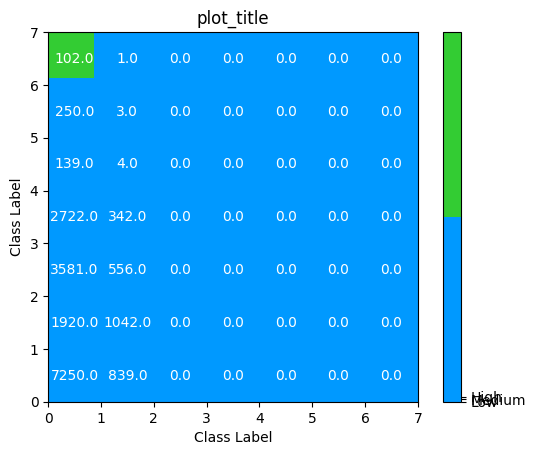

In [40]:
plot_cf_heatmap(data=bert_cf,plot_title="bert-base-uncased")

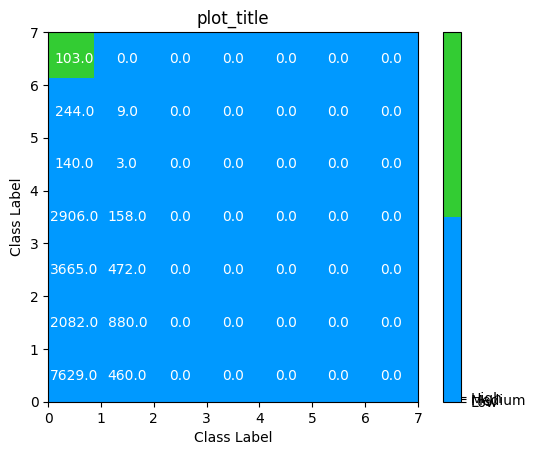

In [41]:
plot_cf_heatmap(data=roberta_cf,plot_title="roberta-base")

From the plot it becomes clear that the model still has a significant issue of imbalance and needs some more exprimentaion and exploration this could also be because the traing set is smaller then validation set hence if we use the whole data and weights loss the results might improve but due to limited time of 3 Days I could not experiment much.

### Future work
1. Train the model bigger traing sample with larger model 
2. Expermient will LLM for classification in few short setting
3. Finetuning LLM for the task of classification using QLORA